##### animaciones

In [1]:
using Plots, Colors

In [2]:
function newton_fractal(f_func, df_func, roots; nmax=50, tol=1e-6)
    colormaps = [:hawaii, :bamako, :turku]
    # dimensiones de la imagen en píxeles
    width, height = 800, 800
    
    # límites del plano complejo
    x_min, x_max = -1.5, 1.5
    y_min, y_max = -1.5, 1.5
    
    # matriz vacía que contendrá los colores de cada píxel
    img = Matrix{RGB{Float64}}(undef, height, width)
    gradients = [cgrad(cm) for cm in colormaps]

    # iteramos sobre cada píxel
    for j in 1:height
        for i in 1:width
            # mapeamos la coordenada del píxel (i, j) a un número complejo z0
            re = x_min + (i - 1) / (width - 1) * (x_max - x_min)
            im = y_max - (j - 1) / (height - 1) * (y_max - y_min)
            z = complex(re, im)

            converged = false
            final_color = colorant"black" # color por defecto para puntos caóticos

            # aplicamos el método de Newton para este punto inicial z
            for k in 1:nmax
                if abs(df(z)) < 1e-9
                    break
                end
                
                step = f_func(z) / df_func(z)
                z = z - step
                
                if abs(step) < tol
                    # encontramos la raíz más cercana
                    distances = [abs(z - r) for r in roots]
                    min_dist, root_idx = findmin(distances)
                    
                    # asignamos el color basado en la raíz y la velocidad de convergencia
                    t = log(k) / log(nmax)
                    final_color = gradients[root_idx][t]
                    
                    converged = true
                    break
                end
            end
            # asignamos el color calculado al píxel en la matriz de la imagen
            img[j, i] = final_color
        end
    end
    return img
end

newton_fractal (generic function with 1 method)

In [3]:
function animate_bisection(func, a_start, b_start, t, roots; nmax=5)
    a, b = a_start, b_start
    
    anim = @animate for i in 1:nmax
        # gráfico base de la función
        plot(t, func.(t), label="f(t)", lw=2, legend=:topright) 
        hline!([0], color=:gray, lw=0.5, label="")
        scatter!(roots, [0], color=:red, label="raíces")

        c = (a + b) / 2.0
        fa, fb, fc = func(a), func(b), func(c)

        # resaltamos el intervalo y los puntos en el frame actual
        plot!([a, b], [0, 0], marker=:vline, color=:black, label="intervalo [a, b]", lw=2)
        scatter!([a, b], [fa, fb], color=:black, label="")
        scatter!([c], [fc], color=:purple, markershape=:star5, markersize=8, label="punto medio c")
        plot!([c, c], [0, fc], color=:purple, linestyle=:dash, label="")

        title!("Método de bisección: Iteración $i")
        xlabel!("t")
        ylabel!("f(t)")
        
        # actualizamos el intervalo para el siguiente frame
        if fa * fc < 0
            b = c
        else
            a = c
        end
    end
    return anim
end

animate_bisection (generic function with 1 method)

In [4]:
function animate_newton(f, df, x0, t, roots; nmax=5)
    xn = x0
    anim = @animate for i in 1:nmax
        fxn = f(xn)
        dfxn = df(xn)
        
        plot(t, f.(t), label="f(t)", lw=2, ylims=(min(f.(t)...)-0.5, max(f.(t)...)+0.5), xlims=(min(t...)+0.1, max(t...)-0.1), legend=:top)
        hline!([0], color=:gray, lw=0.5, label="")
        scatter!(roots, [0], color=:red, label="raíces")

        # dibuja la recta tangente para el frame actual
        tangent(x) = dfxn * (x - xn) + fxn
        plot!(t, tangent.(t), color=:green, linestyle=:dash, label="tangente")
        
        x_next = xn - fxn / dfxn

        # resaltamos la transición en el frame actual
        scatter!([xn], [fxn], color=:black, markersize=5, label="punto actual tᵢ")
        plot!([xn, x_next], [fxn, 0], color=:black, arrow=true, label="")
        scatter!([x_next], [0], color=:purple, markershape=:star5, markersize=8, label="siguiente aprox. tᵢ₊₁")

        title!("Método de newton-raphson: Iteración $i")
        xlabel!("t")
        ylabel!("f(t)")

        # actualiza para el siguiente frame
        xn = x_next
    end
    return anim
end

animate_newton (generic function with 1 method)

In [5]:
function animate_secant(func, x0_start, x1_start, t, roots; nmax=4)
    x0, x1 = x0_start, x1_start
    anim = @animate for i in 1:nmax
        fx0, fx1 = func(x0), func(x1)
        
        plot(t, func.(t), label="f(t)", lw=2, ylims=(-2, 2.5), xlims=(min(t...)+0.1, max(t...)-0.1), legend=:top)
        hline!([0], color=:gray, lw=0.5, label="")
        scatter!(roots, [0, 0], color=:red, label="raíces")

        # dibujamos la recta secante para el frame actual
        slope = (fx1 - fx0) / (x1 - x0)
        secant(x) = slope * (x - x1) + fx1
        plot!(t, secant.(t), color=:green, linestyle=:dash, label="secante")
        
        x_next = x1 - fx1 * (x1 - x0) / (fx1 - fx0)

        # resaltamos la transición
        scatter!([x0, x1], [fx0, fx1], color=:black, markersize=5, label="puntos actuales")
        plot!([x1, x_next], [fx1, 0], color=:black, arrow=true, label="")
        scatter!([x_next], [0], color=:purple, markershape=:star5, markersize=8, label="siguiente aprox.")

        title!("Método de la Secante: Iteración $i")
        xlabel!("Tiempo (t)")

        # actualizamos para el siguiente frame
        x0, x1 = x1, x_next
    end
    return anim
end

animate_secant (generic function with 1 method)

# <center> Ecuaciones no lineales

Queremos encontrar la raíz de una función no lineal $f(x)$, es decir, encontrar un valor $x$ tal que $f(x)=0$. A diferencia de las ecuaciones lineales, no existe una fórmula general para resolver $f(x)=0$, por lo que dependemos de métodos iterativos que generan una secuencia de aproximaciones $x0,x1,x2,...$ que, idealmente, convergen a la raíz verdadera.

Se pueden clasificar en:

* Métodos de intervalo (o cerrados): Requieren un intervalo inicial $[a,b]$ que contenga la raíz. Su principal ventaja es que la convergencia está garantizada.

* Métodos abiertos: Requieren una o más suposiciones iniciales, pero no necesariamente un intervalo que encierre la raíz. Suelen converger mucho más rápido, pero la convergencia no está garantizada y son sensibles a la elección del punto inicial.

Vamos a ejemplificar encontrando las raíces de la función

$$ f(x) = \sin(x) + 0.1x^2 - 1$$

In [6]:
# función del problema
f(t) = sin(t) + 0.1*t^2 - 1
# su derivada
df(t) = cos(t) + 0.2*t

roots = [-3.149596, 1.082042, 3.106816, 4.426535] # raíces
t = -5:0.1:5  # arreglo con valores desde 0 hasta 12 con incrementos de 0.1

-5.0:0.1:5.0

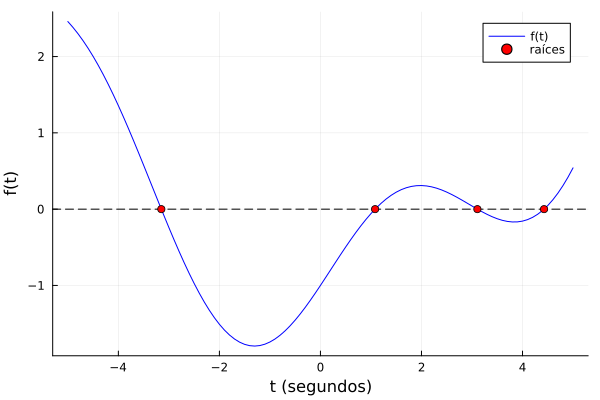

In [7]:
p = plot(t, f.(t),
    color=:blue,
    label="f(t)",
    xlabel="t (segundos)",
    ylabel="f(t)",
    grid=true,
    legend=:topright)
# línea horizontal en y=0 para ver las raíces
hline!([0], linestyle=:dash, color=:black, label="")
scatter!(roots, [0,0], color=:red, label="raíces")
display(p)

## Método de bisección

In [8]:
function biseccion(func, a, b; tol=1e-6, nmax=100)
    if func(a) * func(b) >= 0
        println("El método de bisección no puede garantizar una raíz en este intervalo.")
        return nothing
    end

    i = 0
    println("i, valor")
    while ((b-a)/2.0 > tol) && (i < nmax)
        c = (a + b) / 2.0
        println("$i, $c")
        if func(c) == 0
            return c
        elseif func(a) * func(c) < 0
            b = c
        else
            a = c
        end
        i += 1
    end
    return (a + b) / 2.0
end

biseccion (generic function with 1 method)

In [9]:
# raíz usando bisección
a, b = -4, 0
rb = biseccion(f, a, b)
println("raíz encontrada por bisección: t = $rb")

i, valor
0, -2.0
1, -3.0
2, -3.5
3, -3.25
4, -3.125
5, -3.1875
6, -3.15625
7, -3.140625
8, -3.1484375
9, -3.15234375
10, -3.150390625
11, -3.1494140625
12, -3.14990234375
13, -3.149658203125
14, -3.1495361328125
15, -3.14959716796875
16, -3.149566650390625
17, -3.1495819091796875
18, -3.1495895385742188
19, -3.1495933532714844
20, -3.149595260620117
raíz encontrada por bisección: t = -3.1495962142944336


[ Info: Saved animation to /home/ultrxvioletx/Fciencias/2026-1analisis_numerico/bisection_animation.gif


Plots.AnimatedGif("/home/ultrxvioletx/Fciencias/2026-1analisis_numerico/bisection_animation.gif")
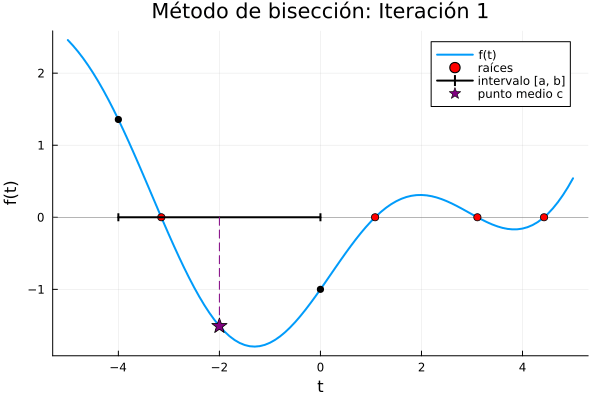

In [10]:
bisection_anim = animate_bisection(f, a, b, t, roots, nmax=5)
gif(bisection_anim, "bisection_animation.gif", fps = 1)

## Método de Newton-Raphson

$$ x_{n+1} = x_n -\frac{f(x_n)}{f'(x_n)} $$

In [11]:
function newton_raphson(func, dfunc, x0; tol=1e-6, nmax=100)
    xn = x0
    println("i, valor")
    for i in 1:nmax
        fxn = func(xn)
        dfxn = dfunc(xn)
        if abs(dfxn) < 1e-12
            println("Derivada cercana a cero. El método de Newton falla.")
            return nothing
        end
        
        x_next = xn - fxn/dfxn
        println("$i, $x_next")
        if abs(x_next - xn) < tol
            return x_next
        end
        xn = x_next
    end
    
    println("Newton-Raphson no convergió.")
    return nothing
end

newton_raphson (generic function with 1 method)

In [12]:
# raíz usando newton-raphson
x0 = -1.8
rnr = newton_raphson(f, df, x0)
println("raíz encontrada por newton_raphson: t = $rnr")

i, valor
1, -4.609675997052634
2, -2.5406590931104294
3, -3.230801111829413
4, -3.149873650178726
5, -3.149596766961598
6, -3.1495967624505226
raíz encontrada por newton_raphson: t = -3.1495967624505226


[ Info: Saved animation to /home/ultrxvioletx/Fciencias/2026-1analisis_numerico/newton_animation.gif


Plots.AnimatedGif("/home/ultrxvioletx/Fciencias/2026-1analisis_numerico/newton_animation.gif")
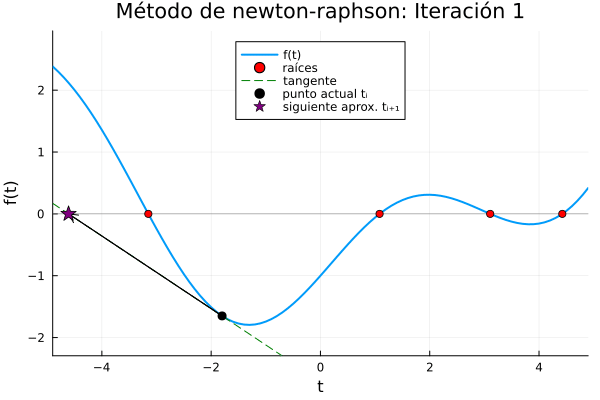

In [13]:
newton_anim = animate_newton(f, df, x0, t, roots, nmax=5)
gif(newton_anim, "newton_animation.gif", fps = 1)

### ¿Hay casos en los que no converge?
#### Caso patológico 1

$$ f(x) = \sqrt[3]{x} $$
$$ f'(x) = \frac{1}{3\sqrt[3]{x^2}} $$

In [14]:
g(t) = cbrt(t)
dg(t) = 1/(3*cbrt(t^2))
roots_g = [0]
t_g = -2:0.01:2
x0_g = 0.1

#newton_raphson(g, dg, x0_g)

0.1

[ Info: Saved animation to /home/ultrxvioletx/Fciencias/2026-1analisis_numerico/newton_animation.gif


Plots.AnimatedGif("/home/ultrxvioletx/Fciencias/2026-1analisis_numerico/newton_animation.gif")
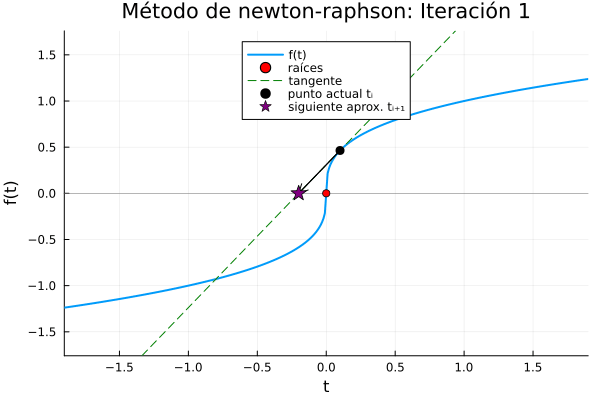

In [15]:
newton_anim = animate_newton(g, dg, x0_g, t_g, roots_g, nmax=5)
gif(newton_anim, "newton_animation.gif", fps = 1)

#### Caso patológico 2

$$ f(x) = sgn(x-2) \sqrt{|x-2|} $$
$$ f'(x) = \frac{(x-2) sgn(x-2)}{2 \sqrt[3]{|x-2|^2}} $$

In [16]:
g(t) = sign(t-2) * sqrt(abs(t-2))
dg(t) = ((t-2)*sign(t-2)) / (2*cbrt(abs(t-2)^2))
roots_g = [0]
t_g = 0:0.01:4
x0_g = 1.0

#newton_raphson(g, dg, x0_g)

1.0

[ Info: Saved animation to /home/ultrxvioletx/Fciencias/2026-1analisis_numerico/newton_animation.gif


Plots.AnimatedGif("/home/ultrxvioletx/Fciencias/2026-1analisis_numerico/newton_animation.gif")
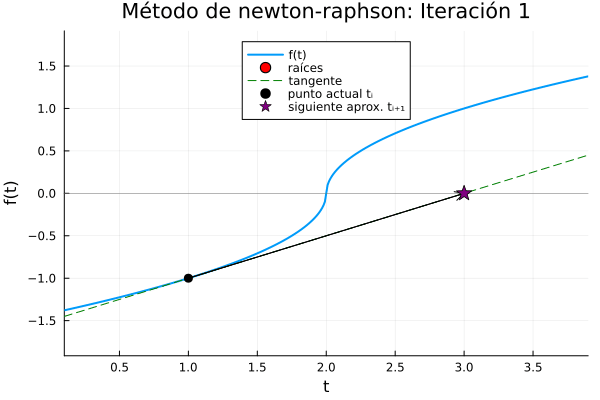

In [17]:
newton_anim = animate_newton(g, dg, x0_g, t_g, roots_g, nmax=20)
gif(newton_anim, "newton_animation.gif", fps = 1)

## Método de secante

$$ x_{n+1} = x_n - f(x_n) \frac{x_n - x_{n-1}}{f(x_n) - f(x_{n-1})} $$

In [18]:
function secante(func, x0, x1; tol=1e-6, nmax=100)
    println("i, valor")
    for i in 1:nmax
        fx0, fx1 = func(x0), func(x1)
        
        if abs(fx1 - fx0) < 1e-12
            println("Diferencia de f(x) muy pequeña. El método de la secante puede fallar.")
            return nothing
        end

        x_next = x1 - fx1*(x1 - x0)/(fx1 - fx0)
        println("$i, $x_next")
        if abs(x_next - x1) < tol
            return x_next
        end
        
        x0, x1 = x1, x_next
    end
        
    println("El método de la secante no convergió.")
    return nothing
end

secante (generic function with 1 method)

In [19]:
x1, x2 = -2, -1.9
rs = secante(f, x1, x2)
println("raíz encontrada por la secante: t = $rs")

i, valor
1, -3.9858481396742933
2, -3.0318579877071956
3, -3.1507874533769913
4, -3.149586752737724
5, -3.149596761750029
6, -3.149596762450523
raíz encontrada por la secante: t = -3.149596762450523


[ Info: Saved animation to /home/ultrxvioletx/Fciencias/2026-1analisis_numerico/secant_animation.gif


Plots.AnimatedGif("/home/ultrxvioletx/Fciencias/2026-1analisis_numerico/secant_animation.gif")
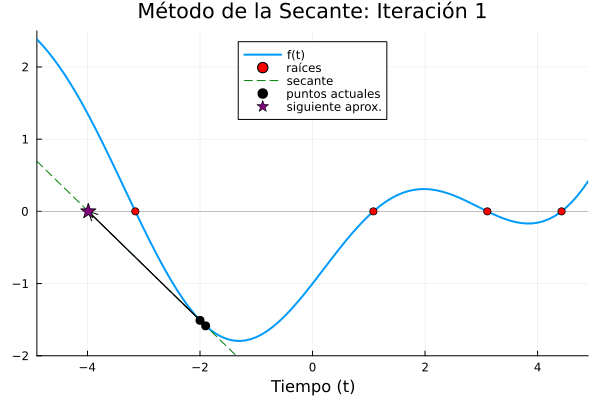

In [20]:
secant_anim = animate_secant(f, x1, x2, t, roots, nmax=4)
gif(secant_anim, "secant_animation.gif", fps = 1)

In [21]:
println("--- Bisección ---")
biseccion(f, a, b)
println()
println("--- Newton-Raphson ---")
newton_raphson(f, df, x0)
println()
println("--- Secante ---")
secante(f, x1, x2)

--- Bisección ---
i, valor
0, -2.0
1, -3.0
2, -3.5
3, -3.25
4, -3.125
5, -3.1875
6, -3.15625
7, -3.140625
8, -3.1484375
9, -3.15234375
10, -3.150390625
11, -3.1494140625
12, -3.14990234375
13, -3.149658203125
14, -3.1495361328125
15, -3.14959716796875
16, -3.149566650390625
17, -3.1495819091796875
18, -3.1495895385742188
19, -3.1495933532714844
20, -3.149595260620117

--- Newton-Raphson ---
i, valor
1, -4.609675997052634
2, -2.5406590931104294
3, -3.230801111829413
4, -3.149873650178726
5, -3.149596766961598
6, -3.1495967624505226

--- Secante ---
i, valor
1, -3.9858481396742933
2, -3.0318579877071956
3, -3.1507874533769913
4, -3.149586752737724
5, -3.149596761750029
6, -3.149596762450523


-3.149596762450523

## Punto fijo

Nos permite encontrar soluciones de la forma $g(x) = x$

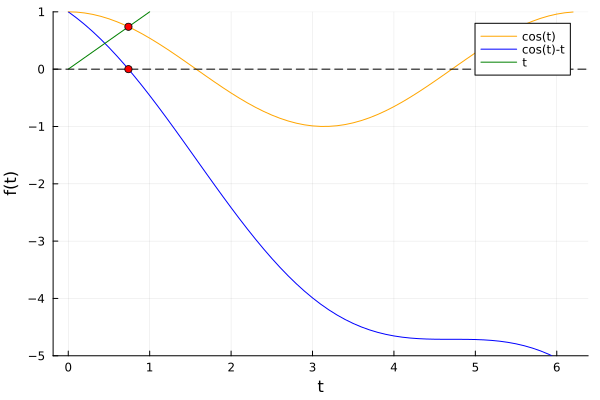

In [22]:
t = 0:0.1:6.2
f(t) = cos(t)
root = [0.7390855263619245]
plot(t, f.(t), color=:orange, label="cos(t)", xlabel="t", ylabel="f(t)", ylims=(-5, 1), grid=true, legend=:topright)
plot!(t, f.(t).-t, color=:blue, label="cos(t)-t")
plot!(t, t, color=:green, label="t")
hline!([0], linestyle=:dash, color=:black, label="")
scatter!(root, [0], color=:red, label="")
scatter!(root, root, color=:red, label="")

In [23]:
function fixed_point(g_func, x0; nmax=100, tol=1e-6)
    x = x0
    history = [x0]
    
    for i in 1:nmax
        x_next = g_func(x)
        push!(history, x_next)
        if abs(x_next - x) < tol
            return x_next, history
        end
        x = x_next
    end
    println("No convergió")
    return x, history
end

fixed_point (generic function with 1 method)

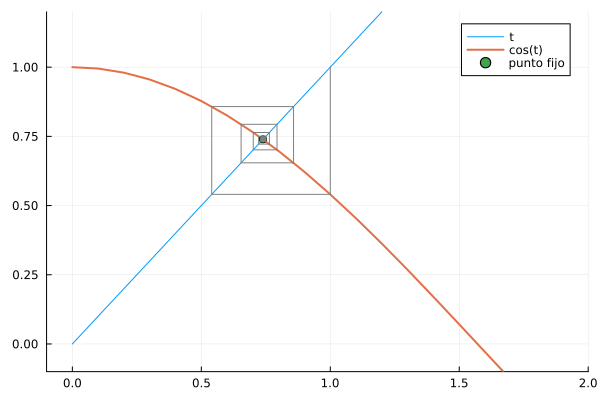

In [24]:
t = 0:0.1:3.2
g(t) = cos(t)
root, history = fixed_point(g, 1.0)

# diagrama de cobweb
plot(t, t, label="t", ylims=(-0.1, 1.2), xlims=(-0.1, 2), legend=:topright)
plot!(t, g.(t), label="cos(t)", lw=2)
scatter!([root], [root], label="punto fijo")

for i in 1:(length(history)-1)
    x_curr, x_next = history[i], history[i+1]
    # Línea vertical a la curva
    plot!([x_curr, x_curr], [x_curr, x_next], color=:gray, label="")
    # Línea horizontal a la recta y=x
    plot!([x_curr, x_next], [x_next, x_next], color=:gray, label="")
end
title!("")

Tenemos un teorema que dice:

Dada una función continua $g(x)$ y derivada continua en $I=[r+\delta, r-\delta]$ alrededor de un punto fijo $r$ de $g(x)$. Si $|g(x)|<1$, entonces la iteración de punto fijo que inicia en $x_0 \in I$ converge al punto fijo (único localmente) $r$ de $g(x)$.

### Ejemplo

$f(x) = x^3 + x - 1$

* $x = 1-x^3 -> g(x) = 1-x^3$
* $x^3 = 1-x -> g(x) = \sqrt[3]{1-x}$

In [25]:
t = -1:0.01:2
g1(t) = 1-t^3
g2(t) = cbrt(1-t)
root, history = fixed_point(g2, 0.9)

(0.6823274841300383, [0.9, 0.46415888336127786, 0.8122293494191408, 0.5726323822751785, 0.7532408601733386, 0.6272265247068619, 0.7196947492650956, 0.6544509126967034, 0.7017297949166449, 0.6681438228540026  …  0.6823342708541619, 0.6823231736235275, 0.682331118882501, 0.6823254303523217, 0.682329503152508, 0.6823265871667064, 0.6823286749154609, 0.6823271801581574, 0.6823282503543587, 0.6823274841300383])

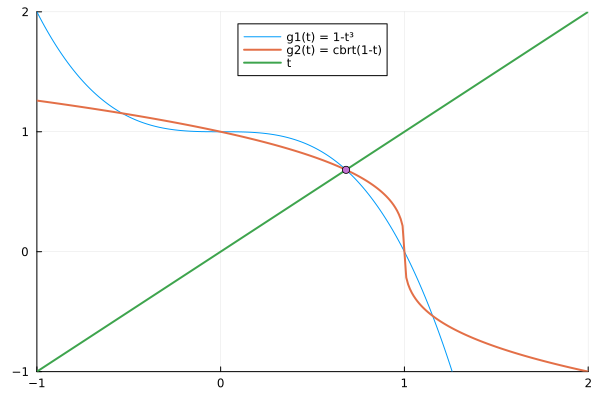

In [26]:
plot(t, g1.(t), label="g1(t) = 1-t³", xlims=(-1, 2), ylims=(-1,2), legend=:top)
plot!(t, g2.(t), label="g2(t) = cbrt(1-t)", lw=2)
plot!(t, t, label="t", lw=2)
scatter!([root], [root], label="")

## Fractales - Método de Newton

¿qué pasaría si aplicamos método de newton a $f(x) = x^2 + 1$?

In [27]:
# La función y su derivada para números complejos
f(z) = z^2 + 1
df(z) = 2*z
x0 = 100-5im

newton_raphson(f, df, x0)

i, valor
1, 49.99501246882793 - 2.5002493765586036im
2, 24.987530186880207 - 1.2506235901776133im
3, 12.473805112230515 - 0.6263107903145662im
4, 6.196919356189067 - 0.31516295494515606im
5, 3.0179825830316287 - 0.16167438196714692im
6, 1.3437917911381096 - 0.0896869859674854im
7, 0.3014645152997122 - 0.06956672334072755im
8, -1.4239820608184783 - 0.3981684692829729im
9, -0.38632526304402726 - 0.29014566277151455im
10, 0.634328319924218 - 0.7665515010771982im
11, -0.0032122148729359923 - 0.7704332891911606im
12, 0.0010997004859384443 - 1.0341908197489724im
13, 3.57561975826762e-5 - 1.000564635381528im
14, 2.0172150616830798e-8 - 1.00000015867843im
15, 3.2008844291484547e-15 - 1.0000000000000124im


3.2008844291484547e-15 - 1.0000000000000124im

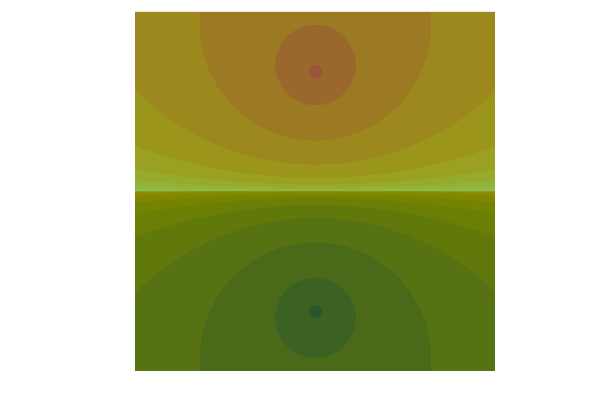

In [28]:
f(z) = z^2 + 1
df(z) = 2*z
roots = [0+1im, 0-1im]

fractal_image = newton_fractal(f, df, roots)
plot(fractal_image, aspect_ratio=:equal, border=:none)

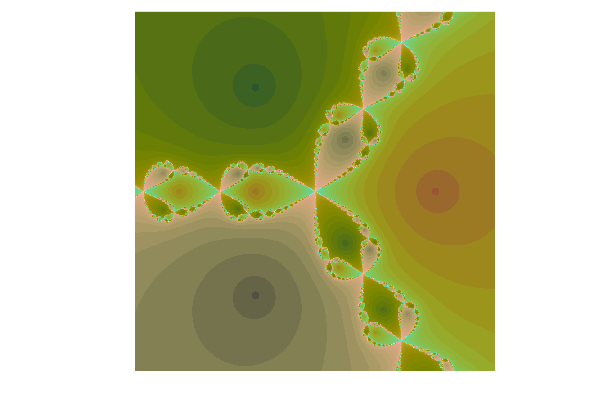

In [29]:
f(z) = z^3 - 1
df(z) = 3z^2
roots = [1.0+0.0im, -0.5+sqrt(3)/2*im, -0.5-sqrt(3)/2*im]

fractal_image = newton_fractal(f, df, roots)
plot(fractal_image, aspect_ratio=:equal, border=:none)